In [51]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import statsmodels.api as sm


In [52]:
data_root = 'C:/Users/mj17071/OneDrive - University of Bristol/Fibre analysis code/'
video_file = 'MJ25_4 full edited.csv'
fiber_file = 'mj25_4_session62025-04-15T08_43_28'

In [53]:
date_match = re.match(r'([a-z]+\d+).*\d{1}(\d{4})-(\d{2})-(\d{2}).*', fiber_file)

mouse = date_match[1]
year = date_match[2]
month = date_match[3]
day = date_match[4]

# comment

date = pd.Timestamp(f'{year}-{month}-{day}')

In [54]:
fiber_df = pd.read_csv(data_root + fiber_file)
initial_time = fiber_df['ComputerTimestamp'].iloc[0]
fiber_df['AbsoluteTimestamp'] = fiber_df['ComputerTimestamp'].apply(lambda ms: date + pd.Timedelta(milliseconds=ms))

initial_event_time = fiber_df['AbsoluteTimestamp'].iloc[0]

fiber_df.head()

,FrameCounter,SystemTimestamp,LedState,ComputerTimestamp,G0,AbsoluteTimestamp
0,0,612.199552,7,3.140851e+07,0.003922,2025-04-15 08:43:28.505024000
1,1,612.216192,2,3.140852e+07,0.021025,2025-04-15 08:43:28.524480000
2,2,612.232832,1,3.140854e+07,0.026522,2025-04-15 08:43:28.538380800
3,3,612.249504,2,3.140856e+07,0.023133,2025-04-15 08:43:28.555225600
4,4,612.266176,1,3.140857e+07,0.028369,2025-04-15 08:43:28.571878400


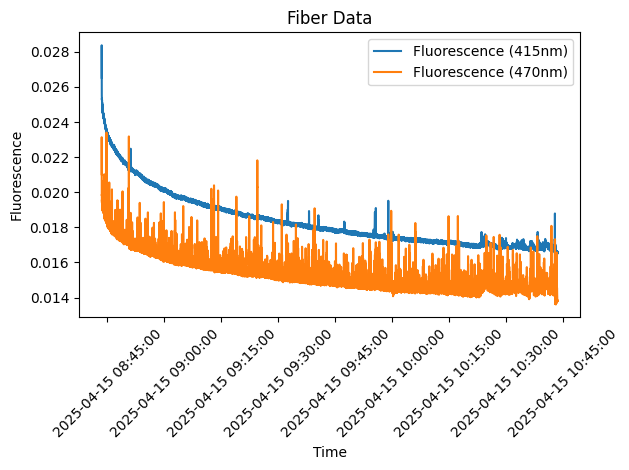

In [55]:
def plot_fiber_data(df):
  led_states = [[1, "Fluorescence (415nm)"], [2, "Fluorescence (470nm)"]]

  for [led_state, label] in led_states:
    subset = df[df['LedState'] == led_state]
    plt.plot(subset['AbsoluteTimestamp'], subset['G0'], label=label)
  plt.title('Fiber Data')
  plt.xlabel('Time')
  plt.ylabel('Fluorescence')
  plt.legend()
  plt.xticks(rotation=45)
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
  plt.tight_layout()
  plt.show()


plot_fiber_data(fiber_df)

In [56]:
video_df = pd.read_csv(data_root + video_file)
video_df.drop(columns=['Unnamed: 3'], inplace=True)

# Add id column containing column number at the start of the dataframe
video_df.insert(0, 'id', range(len(video_df)))

video_df['AbsoluteTimestamp'] = video_df['Aligned to fibre start'].apply(
  lambda s: initial_event_time + pd.Timedelta(seconds=s))

window_size_seconds = 10

video_df['window_start'] = video_df['AbsoluteTimestamp'] - pd.Timedelta(seconds=window_size_seconds / 2)
video_df['window_end'] = video_df['AbsoluteTimestamp'] + pd.Timedelta(seconds=window_size_seconds / 2)

video_df.head()

,id,Event Type,Start Time,End Time,Aligned to fibre start,End Aligned,AbsoluteTimestamp,window_start,window_end
0,0,nose poke into aperture,67.848487,NaN,1.848487,NaN,2025-04-15 08:43:30.353511000,2025-04-15 08:43:25.353511000,2025-04-15 08:43:35.353511000
1,1,nose poke into aperture,153.101319,NaN,87.101319,NaN,2025-04-15 08:44:55.606343000,2025-04-15 08:44:50.606343000,2025-04-15 08:45:00.606343000
2,2,nose poke into aperture,338.771444,NaN,272.771444,NaN,2025-04-15 08:48:01.276467999,2025-04-15 08:47:56.276467999,2025-04-15 08:48:06.276467999
3,3,nose poke into aperture,340.287257,NaN,274.287257,NaN,2025-04-15 08:48:02.792281000,2025-04-15 08:47:57.792281000,2025-04-15 08:48:07.792281000
4,4,nose poke into aperture,343.288880,NaN,277.288880,NaN,2025-04-15 08:48:05.793904000,2025-04-15 08:48:00.793904000,2025-04-15 08:48:10.793904000


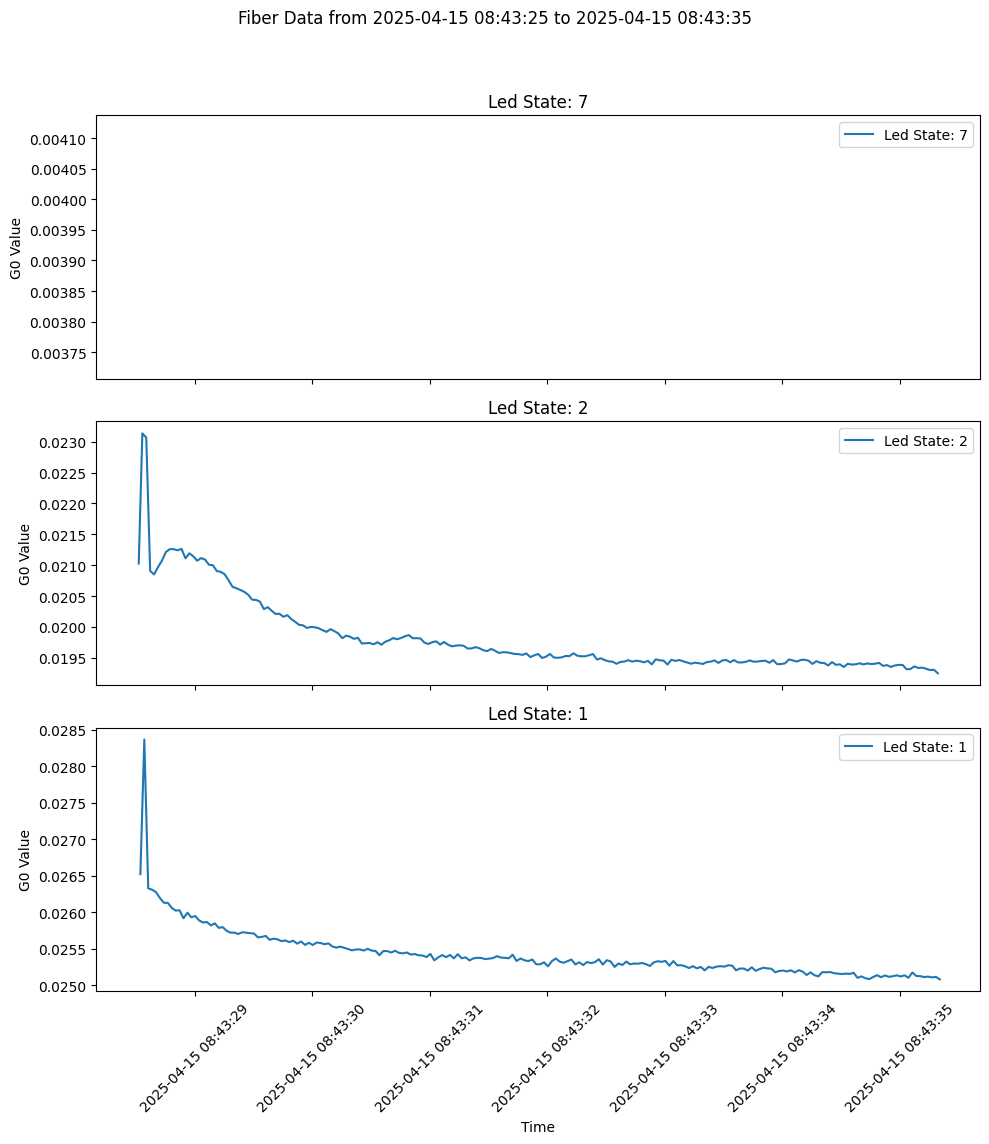

<Figure size 640x480 with 0 Axes>

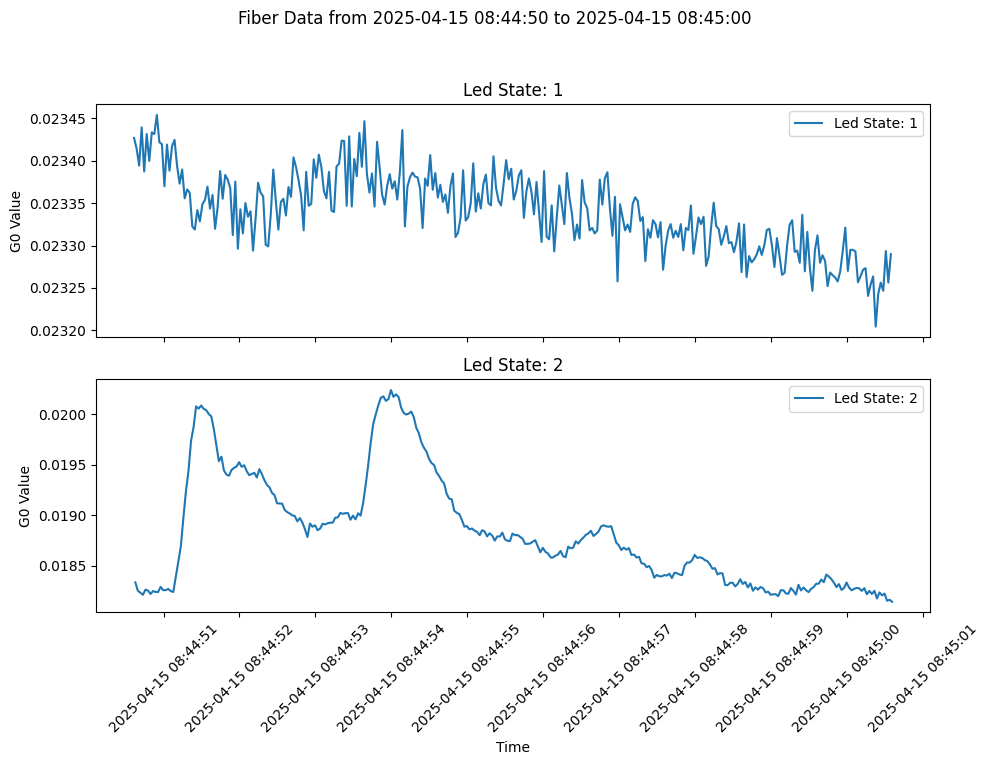

<Figure size 640x480 with 0 Axes>

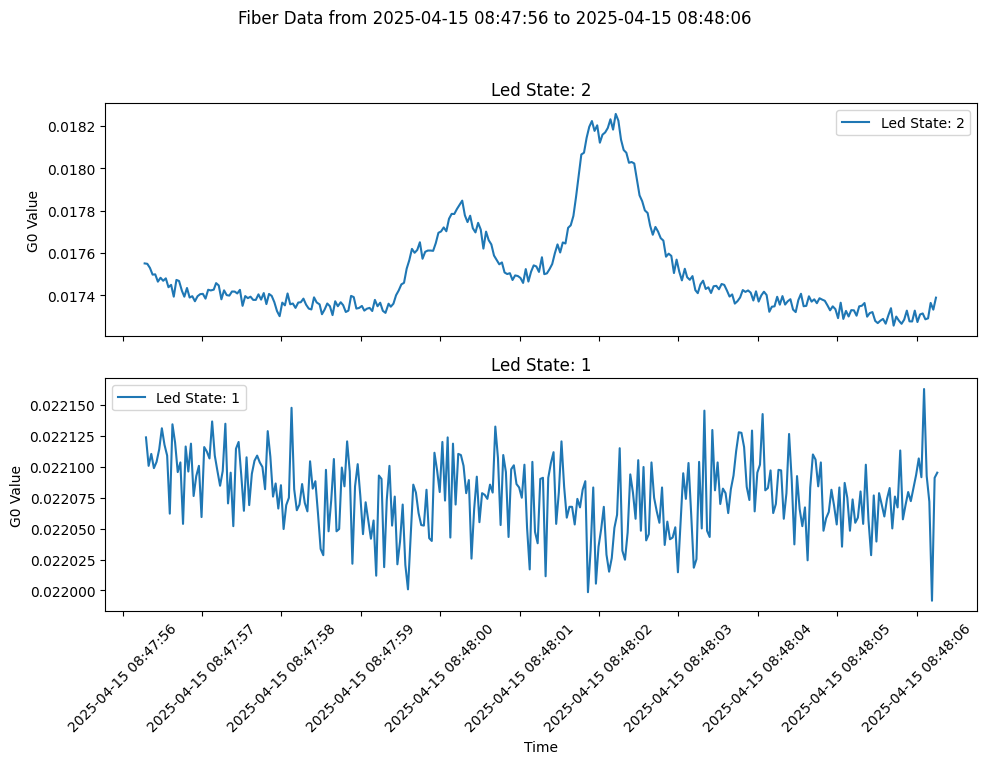

<Figure size 640x480 with 0 Axes>

In [57]:
# For each row in video_df, create a plot of the fiber_df data within the window defined by window_start and window_end, with each Led State on a separate sub

def plot_fiber_data_in_window(row):
  window_start = row['window_start']
  window_end = row['window_end']

  filtered_fiber_df = fiber_df[
    (fiber_df['AbsoluteTimestamp'] >= window_start) & (fiber_df['AbsoluteTimestamp'] <= window_end)]

  if filtered_fiber_df.empty:
    return None

  led_states = filtered_fiber_df['LedState'].unique()
  n_leds = len(led_states)
  fig, axes = plt.subplots(n_leds, 1, figsize=(10, 4 * n_leds), sharex=True)

  if n_leds == 1:
    axes = [axes]

  for ax, led_state in zip(axes, led_states):
    led_data = filtered_fiber_df[filtered_fiber_df['LedState'] == led_state]
    ax.plot(led_data['AbsoluteTimestamp'], led_data['G0'], label=f'Led State: {led_state}')
    ax.set_title(f'Led State: {led_state}')
    ax.set_ylabel('G0 Value')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

  axes[-1].set_xlabel('Time')
  start_str = window_start.strftime('%Y-%m-%d %H:%M:%S')
  end_str = window_end.strftime('%Y-%m-%d %H:%M:%S')
  fig.suptitle(f'Fiber Data from {start_str} to {end_str}')
  plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.95))
  plt.show()
  return plt.clf()  # Clear the figure for the next plot

# Apply the function to each row in video_df
for index, data_row in video_df.head(3).iterrows():
  plot_fiber_data_in_window(data_row)
  plt.pause(0.1)  # Pause to allow the plot to render before moving to the next

# new code

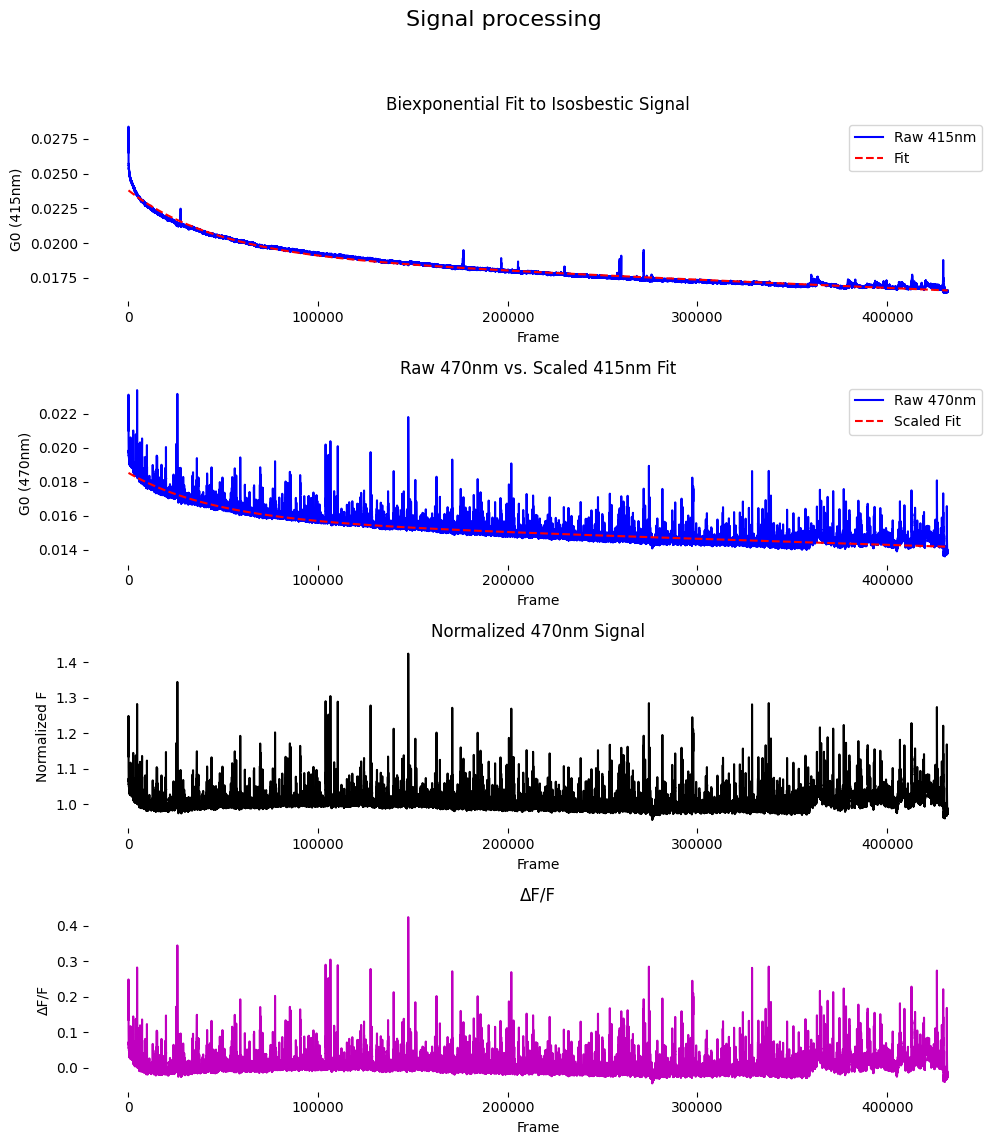

,FrameCounter,SystemTimestamp,LedState,ComputerTimestamp,G0,AbsoluteTimestamp,Normalized,DeltaF_F
1,1,612.216192,2,3.140852e+07,0.021025,2025-04-15 08:43:28.524480000,1.134822,0.134822
3,3,612.249504,2,3.140856e+07,0.023133,2025-04-15 08:43:28.555225600,1.248606,0.248606
5,5,612.282848,2,3.140859e+07,0.023066,2025-04-15 08:43:28.588480000,1.245016,0.245016
7,7,612.316192,2,3.140862e+07,0.020907,2025-04-15 08:43:28.621644800,1.128467,0.128467
9,9,612.349504,2,3.140866e+07,0.020849,2025-04-15 08:43:28.655052800,1.125372,0.125372


In [58]:
def biexp(x, a, b, c, d):
  """Match MATLAB's exp2 model: a*exp(b*x) + c*exp(d*x) with overflow protection"""
  # Scale x to prevent overflow in exponentials
  x_scaled = x / np.max(x) if np.max(np.abs(x)) > 0 else x
  # Adjust the rate parameters to compensate for scaling
  b_scaled = b * np.max(x) if np.max(np.abs(x)) > 0 else b
  d_scaled = d * np.max(x) if np.max(np.abs(x)) > 0 else d
  return a * np.exp(b_scaled * x_scaled) + c * np.exp(d_scaled * x_scaled)


def pre_process_data():
  # Extract 415nm signal - similar to MATLAB
  isosbestic_data = fiber_df.loc[fiber_df['LedState'] == 1, 'G0'].values
  isosbestic_frame = fiber_df.loc[fiber_df['LedState'] == 1, 'FrameCounter'].values

  # Better initial guesses to avoid overflow
  p0 = [max(isosbestic_data) / 2, -0.0001, max(isosbestic_data) / 2, -0.00001]

  # Apply bounds to prevent extreme parameter values
  bounds = ([0, -np.inf, 0, -np.inf], [np.inf, 0, np.inf, 0])

  popt, pcov = curve_fit(biexp, isosbestic_frame, isosbestic_data,
                         p0=p0, maxfev=10000, bounds=bounds)

  # Extract 470nm signal - similar to MATLAB
  dLight_data = fiber_df.loc[fiber_df['LedState'] == 2, 'G0'].values
  dLight_frame = fiber_df.loc[fiber_df['LedState'] == 2, 'FrameCounter'].values

  # Evaluate fit at dLight frames - same as MATLAB approach
  isosbestic_fit_at_470 = biexp(dLight_frame, *popt)

  # Robust fit - similar to MATLAB's robustfit with bisquare
  valid_mask = np.isfinite(dLight_data) & np.isfinite(isosbestic_fit_at_470)
  X = sm.add_constant(isosbestic_fit_at_470[valid_mask])
  robust_model = sm.RLM(dLight_data[valid_mask], X, M=sm.robust.norms.TukeyBiweight())
  robust_results = robust_model.fit()
  fit2 = robust_results.params

  # Scale fit to match 470nm data
  scaled_fit = isosbestic_fit_at_470 * fit2[1] + fit2[0]
  normalized_F = dLight_data / scaled_fit
  dF_F = (dLight_data - scaled_fit) / scaled_fit

  plt.figure(figsize=(10, 12))
  plt.suptitle(f'Signal processing', fontsize=16)

  # Panel 1: Biexponential fit
  plt.subplot(4, 1, 1)
  plt.plot(isosbestic_frame, isosbestic_data, 'b', label='Raw 415nm')
  plt.plot(isosbestic_frame, biexp(isosbestic_frame, *popt), 'r--', linewidth=1.5, label='Fit')
  plt.xlabel('Frame')
  plt.ylabel('G0 (415nm)')
  plt.title('Biexponential Fit to Isosbestic Signal')
  plt.legend()
  plt.grid(False)
  plt.box(False)

  # Panel 2: 470nm vs scaled fit
  plt.subplot(4, 1, 2)
  plt.plot(dLight_frame, dLight_data, 'b', label='Raw 470nm')
  plt.plot(dLight_frame, scaled_fit, 'r--', linewidth=1.5, label='Scaled Fit')
  plt.xlabel('Frame')
  plt.ylabel('G0 (470nm)')
  plt.title('Raw 470nm vs. Scaled 415nm Fit')
  plt.legend()
  plt.grid(False)
  plt.box(False)

  # Panel 3: Normalized F
  plt.subplot(4, 1, 3)
  plt.plot(dLight_frame, normalized_F, 'k')
  plt.xlabel('Frame')
  plt.ylabel('Normalized F')
  plt.title('Normalized 470nm Signal')
  plt.grid(False)
  plt.box(False)

  # Panel 4: ΔF/F
  plt.subplot(4, 1, 4)
  plt.plot(dLight_frame, dF_F, 'm')
  plt.xlabel('Frame')
  plt.ylabel('ΔF/F')
  plt.title('ΔF/F')
  plt.grid(False)
  plt.box(False)

  plt.tight_layout(rect=(0, 0.03, 1, 0.95))
  plt.show()

  return [normalized_F, dF_F]



[normalized, delta] = pre_process_data()

fiber_data_with_normalized = fiber_df[fiber_df['LedState'] == 2].copy()
fiber_data_with_normalized['Normalized'] = normalized
fiber_data_with_normalized['DeltaF_F'] = delta

fiber_data_with_normalized.head()


C:\Users\mj17071\AppData\Local\Temp\ipykernel_1456\1204744998.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(unique_event_types_lower))


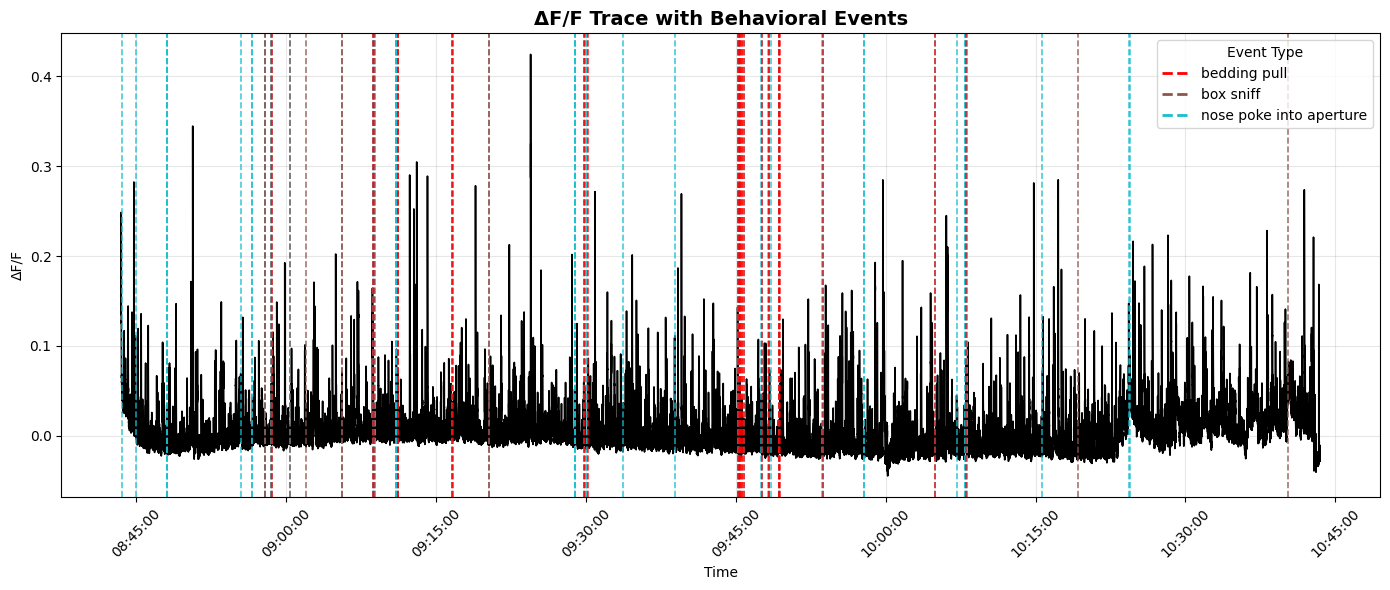

In [59]:
#Chat code 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

def plot_full_session_with_events(fiber_data_with_normalized, video_df):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot full ΔF/F trace
    ax.plot(fiber_data_with_normalized['AbsoluteTimestamp'], fiber_data_with_normalized['DeltaF_F'],
            color='black', linewidth=1.2, label='ΔF/F')

    # Normalize event type strings
    video_df = video_df.copy()
    video_df['Event Type'] = video_df['Event Type'].astype(str).str.strip()
    video_df['Event Type Lower'] = video_df['Event Type'].str.lower()

    # Get unique lowercased types and map back to original display names
    unique_event_types_lower = video_df['Event Type Lower'].unique()
    lower_to_original = video_df.drop_duplicates('Event Type Lower').set_index('Event Type Lower')['Event Type'].to_dict()

    # Assign colors
    colors = {}
    color_map = cm.get_cmap('tab10', len(unique_event_types_lower))
    for i, etype_lower in enumerate(sorted(unique_event_types_lower)):
        if etype_lower == 'bedding pull':
            colors[etype_lower] = 'red'
        else:
            colors[etype_lower] = color_map(i)

    # Plot vertical lines
    for etype_lower in unique_event_types_lower:
        color = colors[etype_lower]
        matching_rows = video_df[video_df['Event Type Lower'] == etype_lower]

        for _, row in matching_rows.iterrows():
            ax.axvline(x=row['AbsoluteTimestamp'], linestyle='--', color=color, alpha=0.8, linewidth=1.2)

    # Custom legend with original names
    from matplotlib.lines import Line2D
    legend_lines = [Line2D([0], [0], color=colors[etype], linestyle='--', linewidth=2)
                    for etype in sorted(unique_event_types_lower)]
    legend_labels = [lower_to_original[etype] for etype in sorted(unique_event_types_lower)]

    ax.legend(legend_lines, legend_labels, title="Event Type", loc='upper right')

    # Formatting
    ax.set_title('ΔF/F Trace with Behavioral Events', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('ΔF/F')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_full_session_with_events(fiber_data_with_normalized, video_df)

# Event counter

In [60]:
# event counter
def analyze_event_pairs(video_df, first_event='nose poke into aperture', second_event='bedding pull', window_seconds=5):
    # Ensure timestamps are sorted
    video_df = video_df.sort_values('AbsoluteTimestamp').reset_index(drop=True)

    # Filter to relevant events
    first_df = video_df[video_df['Event Type'] == first_event].copy()
    second_df = video_df[video_df['Event Type'] == second_event].copy()

    # Initialize counters
    preceded_by_first = 0
    not_preceded_by_first = 0
    not_followed_by_second = 0

    # Check each second_event: was it preceded by a first_event within the window?
    for _, second_row in second_df.iterrows():
        t = second_row['AbsoluteTimestamp']
        recent_firsts = first_df[
            (first_df['AbsoluteTimestamp'] >= t - pd.Timedelta(seconds=window_seconds)) &
            (first_df['AbsoluteTimestamp'] < t)
        ]
        if not recent_firsts.empty:
            preceded_by_first += 1
        else:
            not_preceded_by_first += 1

    # Check each first_event: was it followed by a second_event within the window?
    for _, first_row in first_df.iterrows():
        t = first_row['AbsoluteTimestamp']
        upcoming_seconds = second_df[
            (second_df['AbsoluteTimestamp'] > t) &
            (second_df['AbsoluteTimestamp'] <= t + pd.Timedelta(seconds=window_seconds))
        ]
        if upcoming_seconds.empty:
            not_followed_by_second += 1

    # Output results
    print(f"✔ '{second_event}' events preceded by '{first_event}' within {window_seconds} sec: {preceded_by_first}")
    print(f"✖ '{second_event}' events NOT preceded by '{first_event}' within {window_seconds} sec: {not_preceded_by_first}")
    print(f"✖ '{first_event}' events NOT followed by '{second_event}' within {window_seconds} sec: {not_followed_by_second}")
    
    return preceded_by_first, not_preceded_by_first, not_followed_by_second
analyze_event_pairs(video_df)

✔ 'bedding pull' events preceded by 'nose poke into aperture' within 5 sec: 21
✖ 'bedding pull' events NOT preceded by 'nose poke into aperture' within 5 sec: 6
✖ 'nose poke into aperture' events NOT followed by 'bedding pull' within 5 sec: 33


(21, 6, 33)

C:\Users\mj17071\AppData\Local\Temp\ipykernel_1456\2256567228.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


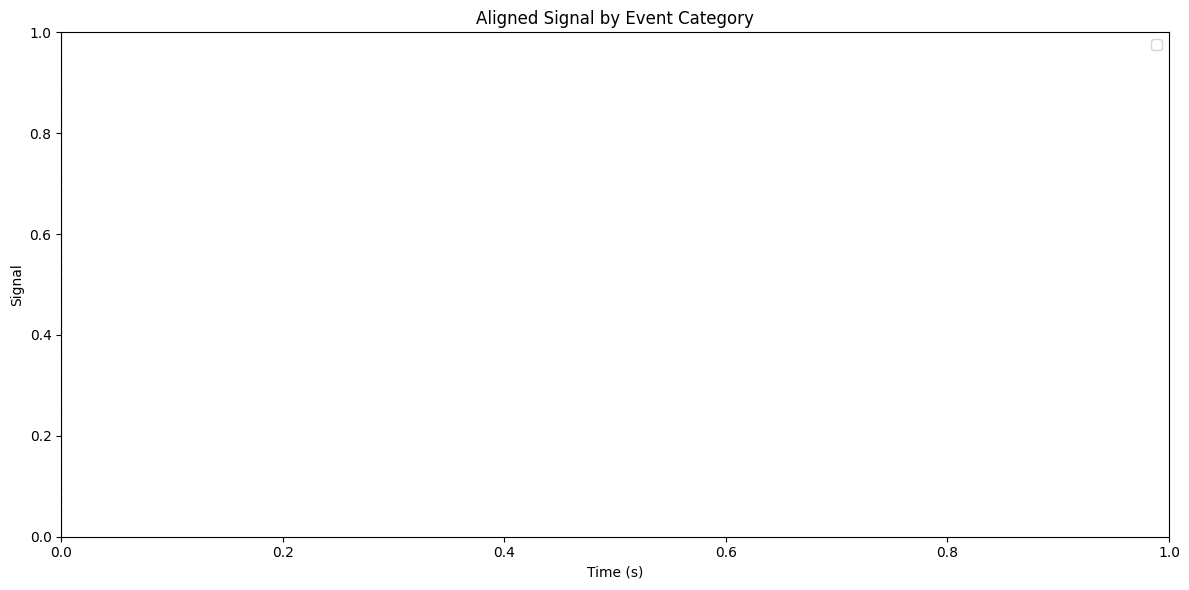

                               DeltaF_F
AbsoluteTimestamp                      
2025-04-15 08:43:28.524480000  0.134822
2025-04-15 08:43:28.555225600  0.248606
2025-04-15 08:43:28.588480000  0.245016
2025-04-15 08:43:28.621644800  0.128467
2025-04-15 08:43:28.655052800  0.125372
Index(['DeltaF_F'], dtype='object')
Preceded traces shape: (0,)
Not preceded traces shape: (0,)
Unfollowed traces shape: (0,)
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Pulls categorized: category
preceded        16
not_preceded    11
Name: count, dtype: int64
Unfollowed pokes: 39


In [77]:
signal_df = fiber_data_with_normalized.set_index('AbsoluteTimestamp')[['DeltaF_F']].sort_index()
def categorize_bedding_pulls(video_df, first_event='nose poke into aperture', second_event='bedding pull', window_seconds=2):
    video_df = video_df.sort_values('AbsoluteTimestamp').reset_index(drop=True)
    pulls = video_df[video_df['Event Type'] == second_event].copy()
    pokes = video_df[video_df['Event Type'] == first_event].copy()

    categories = []
    for _, row in pulls.iterrows():
        t = row['AbsoluteTimestamp']
        recent_pokes = pokes[
            (pokes['AbsoluteTimestamp'] >= t - pd.Timedelta(seconds=window_seconds)) &
            (pokes['AbsoluteTimestamp'] < t)
        ]
        if not recent_pokes.empty:
            categories.append('preceded')
        else:
            categories.append('not_preceded')

    pulls['category'] = categories
    return pulls
def find_unfollowed_nose_pokes(video_df, first_event='nose poke into aperture', second_event='bedding pull', window_seconds=2):
    video_df = video_df.sort_values('AbsoluteTimestamp').reset_index(drop=True)
    pokes = video_df[video_df['Event Type'] == first_event].copy()
    pulls = video_df[video_df['Event Type'] == second_event].copy()

    unfollowed_pokes = []
    for _, poke in pokes.iterrows():
        t = poke['AbsoluteTimestamp']
        nearby_pulls = pulls[
            (pulls['AbsoluteTimestamp'] > t) &
            (pulls['AbsoluteTimestamp'] <= t + pd.Timedelta(seconds=window_seconds))
        ]
        if nearby_pulls.empty:
            unfollowed_pokes.append(poke)

    return pd.DataFrame(unfollowed_pokes)
def extract_traces(events, signal_df, window=(-5, 10), signal_column='DeltaF_F'):
    traces = []
    times = np.arange(window[0], window[1], signal_df.index.to_series().diff().median().total_seconds())
    for _, row in events.iterrows():
        center_time = row['AbsoluteTimestamp']
        start = center_time + pd.Timedelta(seconds=window[0])
        end = center_time + pd.Timedelta(seconds=window[1])
        snippet = signal_df.loc[(signal_df.index >= start) & (signal_df.index < end)].copy()
        snippet = snippet.iloc[:len(times)]  # ensure same length
        if len(snippet) == len(times):
            traces.append(snippet[signal_column].values)
    return np.array(traces), times
import matplotlib.pyplot as plt

# Categorize pulls
pulls_df = categorize_bedding_pulls(video_df)
unfollowed_pokes_df = find_unfollowed_nose_pokes(video_df)

# Get signal-aligned traces
preceded_traces, t = extract_traces(pulls_df[pulls_df['category'] == 'preceded'], signal_df, signal_column='DeltaF_F')
not_preceded_traces, _ = extract_traces(pulls_df[pulls_df['category'] == 'not_preceded'], signal_df, signal_column='DeltaF_F')
unfollowed_traces, _ = extract_traces(unfollowed_pokes_df, signal_df, signal_column='DeltaF_F')

# Plot
plt.figure(figsize=(12, 6))

for traces, label, color in zip(
    [preceded_traces, not_preceded_traces, unfollowed_traces],
    ['Bedding pull preceded by poke', 'Bedding pull NOT preceded', 'Poke NOT followed by pull'],
    ['red', 'blue', 'green']
):
    if len(traces) > 0:
        mean_trace = np.mean(traces, axis=0)
        sem = np.std(traces, axis=0) / np.sqrt(traces.shape[0])
        plt.plot(t, mean_trace, label=label, color=color)
        plt.fill_between(t, mean_trace - sem, mean_trace + sem, alpha=0.2, color=color)

plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Aligned Signal by Event Category')
plt.legend()
plt.tight_layout()
plt.show()
print(signal_df.head())
print(signal_df.columns)
print(f"Preceded traces shape: {preceded_traces.shape}")
print(f"Not preceded traces shape: {not_preceded_traces.shape}")
print(f"Unfollowed traces shape: {unfollowed_traces.shape}")
print(type(signal_df.index[0]))
print(type(pulls_df['AbsoluteTimestamp'].iloc[0]))
print("Pulls categorized:", pulls_df['category'].value_counts())
print("Unfollowed pokes:", len(unfollowed_pokes_df))



In [62]:
def plot_delta_f_for_row(row):
    window_start = row['window_start']
    window_end = row['window_end']
    event_type = row['Event Type']
    event_time = row['AbsoluteTimestamp']

    filtered_fiber_df = fiber_data_with_normalized[
        (fiber_data_with_normalized['AbsoluteTimestamp'] >= window_start) & (fiber_data_with_normalized['AbsoluteTimestamp'] <= window_end)]

    if filtered_fiber_df.empty:
        return None

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot ΔF/F as the main metric
    ax.plot(filtered_fiber_df['AbsoluteTimestamp'], filtered_fiber_df['DeltaF_F'], 'm-',
            linewidth=2.5, label='ΔF/F', zorder=3)

    # Add baseline reference at y=0
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.7, label='Baseline')

    # Add event line
    ax.axvline(x=event_time, color='r', linestyle='-', linewidth=2, label='Event', zorder=4)

    # Set y limits with padding for better visualization
    delta_min = min(filtered_fiber_df['DeltaF_F'].min(), 0)
    delta_max = filtered_fiber_df['DeltaF_F'].max()
    y_padding = (delta_max - delta_min) * 0.2
    ax.set_ylim(delta_min - y_padding, delta_max + y_padding)

    # Format axes
    ax.set_xlabel('Time')
    ax.set_ylabel('ΔF/F', fontweight='bold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax.tick_params(axis='x', rotation=45)

    # Add grid and legend
    ax.grid(alpha=0.15)
    ax.legend(loc='upper left')

    fig.suptitle(f'{event_type} Fiber Data from {window_start.strftime("%Y-%m-%d %H:%M:%S")} to {window_end.strftime("%Y-%m-%d %H:%M:%S")}')
    fig.tight_layout()
    plt.show()

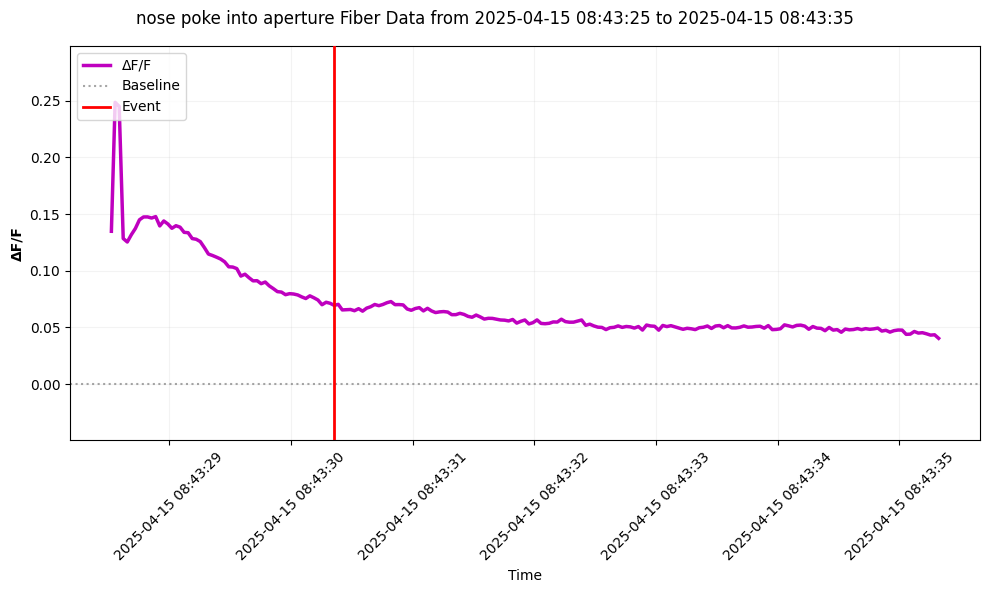

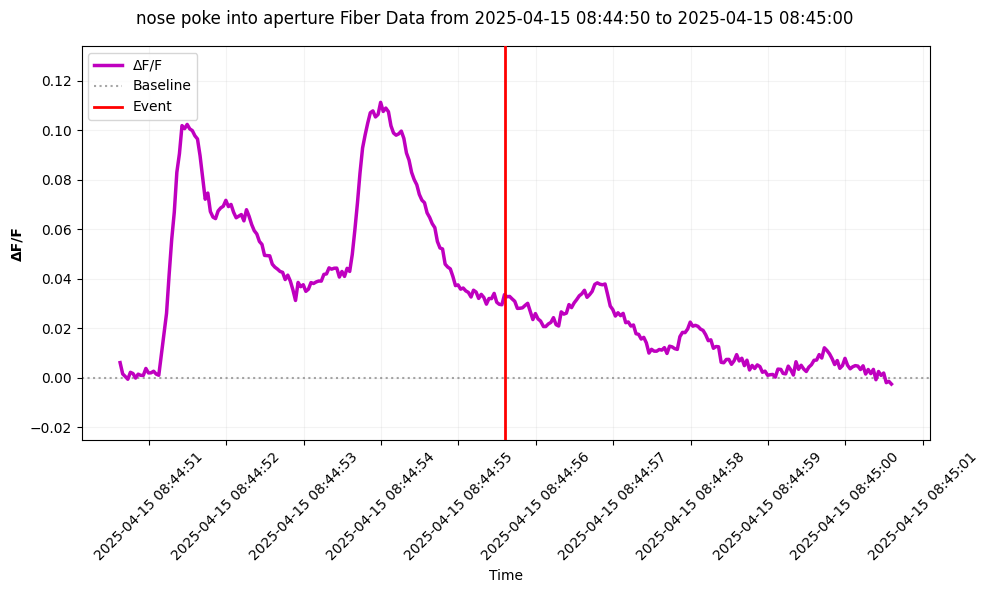

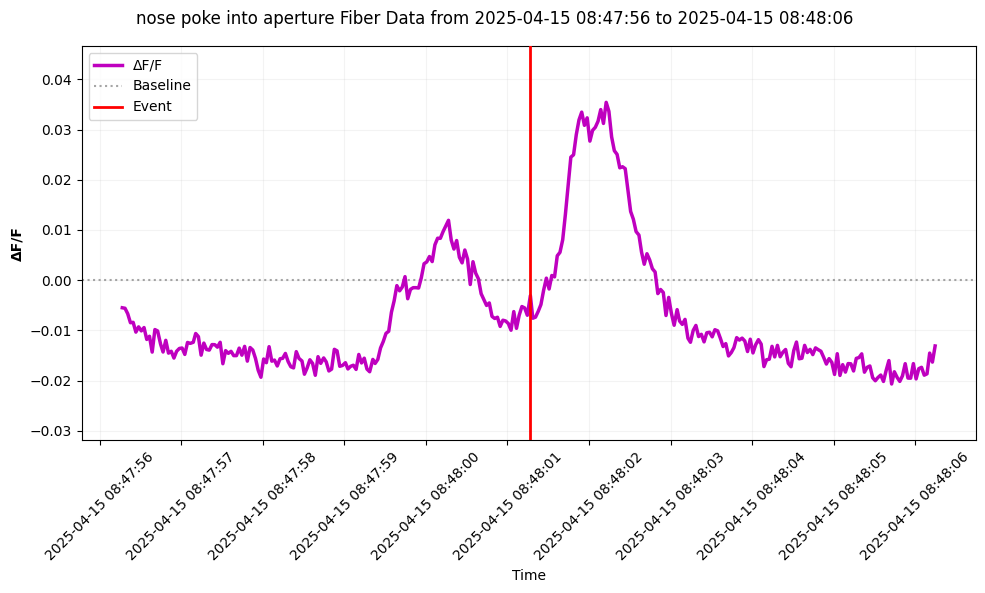

In [63]:
# Apply the function to first 10 rows in video_df
for index, data_row in video_df.head(3).iterrows():
    plot_delta_f_for_row(data_row)
    plt.pause(0.1)  # Pause to allow the plot to render before moving to the next

In [64]:
def plot_average_delta_f_by_event_type(video_df, fiber_data_with_normalized, window_size_seconds=10):
    # Get unique event types
    event_types = video_df['Event Type'].unique()

    # For each event type
    for event_type in event_types:
        # Get all rows for this event type
        event_rows = video_df[video_df['Event Type'] == event_type]

        print(f"Processing event type: {event_type} ({len(event_rows)} events)")

        # Initialize list to store aligned time series data
        all_time_series = []

        # Process each window for this event type
        for _, row in event_rows.iterrows():
            event_time = row['AbsoluteTimestamp']
            window_start = row['window_start']
            window_end = row['window_end']

            # Get fiber data within this window
            filtered_fiber_df = fiber_data_with_normalized[
                (fiber_data_with_normalized['AbsoluteTimestamp'] >= window_start) &
                (fiber_data_with_normalized['AbsoluteTimestamp'] <= window_end)]

            if not filtered_fiber_df.empty:
                # Convert timestamps to seconds relative to event time (0 = event time)
                relative_times = [(ts - event_time).total_seconds() for ts in filtered_fiber_df['AbsoluteTimestamp']]
                delta_f_values = filtered_fiber_df['DeltaF_F'].values

                # Only add if we have enough valid data points
                if len(relative_times) > 5:  # Require at least 5 data points
                    all_time_series.append((relative_times, delta_f_values))

        if not all_time_series:
            print(f"No valid data found for event type: {event_type}")
            continue

        print(f"Found {len(all_time_series)} valid windows for {event_type}")

        # Create a common time grid
        time_grid = np.linspace(-window_size_seconds/2, window_size_seconds/2, 1000)

        # Interpolate each time series onto the common grid
        interpolated_series = []
        for rel_times, delta_values in all_time_series:
            # Only interpolate within the actual range of data to avoid extrapolation
            min_time = max(-window_size_seconds/2, min(rel_times))
            max_time = min(window_size_seconds/2, max(rel_times))

            # Generate mask for valid interpolation range
            valid_mask = (time_grid >= min_time) & (time_grid <= max_time)

            # Initialize with all NaNf
            interp_values = np.full_like(time_grid, np.nan

            # Only interpolate within valid range
            interp_values[valid_mask] = np.interp(
                time_grid[valid_mask], rel_times, delta_values)

            interpolated_series.append(interp_values)

        # Convert to numpy array for calculations
        interpolated_array = np.array(interpolated_series)

        # Calculate number of valid values at each time point
        n_valid = np.sum(~np.isnan(interpolated_array), axis=0)

        # Require at least 2 valid values to compute statistics
        valid_times = n_valid >= 2

        if not np.any(valid_times):
            print(f"No time points have enough valid data for event type: {event_type}")
            continue

        # Filter time grid to only points with enough data
        filtered_time_grid = time_grid[valid_times]
        filtered_array = interpolated_array[:, valid_times]

        # Calculate statistics only on filtered data
        mean_delta_f = np.nanmean(filtered_array, axis=0)
        std_delta_f = np.nanstd(filtered_array, axis=0)
        sem_delta_f = std_delta_f / np.sqrt(n_valid[valid_times])

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot mean line
        ax.plot(filtered_time_grid, mean_delta_f, 'b-', linewidth=2.5, label='Mean ΔF/F')

        # Add shaded area for standard error
        ax.fill_between(filtered_time_grid,
                       mean_delta_f - sem_delta_f,
                       mean_delta_f + sem_delta_f,
                       alpha=0.3, color='b', label='SEM')

        # Add baseline and event lines
        ax.axhline(y=0, color='gray', linestyle=':', alpha=0.7, label='Baseline')
        ax.axvline(x=0, color='r', linestyle='-', linewidth=2, label='Event', zorder=4)

        # Format axes
        ax.set_xlabel('Time relative to event (seconds)')
        ax.set_ylabel('ΔF/F', fontweight='bold')
        ax.grid(alpha=0.15)
        ax.legend(loc='upper left')

        # Set x-axis limits to the original window size
        ax.set_xlim(-window_size_seconds/2, window_size_seconds/2)

        # Add title showing event type and number of traces
        n_traces = len(all_time_series)
        ax.set_title(f'Average response to {event_type} (n={n_traces})', fontweight='bold')

        fig.tight_layout()
        plt.show()

# Call the function to plot average ΔF/F by event type
plot_average_delta_f_by_event_type(video_df, fiber_data_with_normalized, window_size_seconds=10)

SyntaxError: '(' was never closed (3711697071.py, line 55)